# RetinaNet scratch work

- (c) 2017 Chris Hodapp
- Inspired by [keras-retinanet](https://github.com/fizyr/keras-retinanet)
- Needs:
  - [pycocotools](https://github.com/cocodataset/cocoapi/tree/master/PythonAPI/pycocotools) from https://github.com/cocodataset/cocoapi
  - NumPy, PIL, matplotlib, Keras, [keras_resnet](https://github.com/broadinstitute/keras-resnet)

## To-do items:

- Double-check training details and hyperparameters on pages 5-6.
- Double-check that I am keeping order in tensors consistent
- For eval, the Keras network needs to include decoding for the box parametrization, which requires the anchors.
- `bbox_decode` / `bbox_encode` have mean/stdev multiplicative factor in keras-retinanet. Is this why I have the different loss on regression? (Also, how much does this affect training?)

### Good ideas
- Resize images & annotations rather than pass right from COCO
- Check network summaries; do number of parameters match?
- Filter out-of-range object boxes & anchors
- Factor out some things I hard-code:
  - Number of classes
  - Pyramid shapes, strides, size
- What is mAP?
- Check that my per-batch tensors are right (i.e. bbox_decode them and plot to look)

## Overall goals/deliverables

1. My blog post explaining how RetinaNet works.
2. A working implementation of RetinaNet that is far simpler than keras-retinanet. A literate implementation would be a good idea, if feasible.
3. A working *understanding* of RetinaNet that can be applied to other things.
4. Documentation to commit to keras-retinanet.

## Other notes & questions

- The paper specifies that only horizontal image flipping is used for data augmentation.  I really don't know why keras-retinanet uses ImageDataGenerator for this, and goes through all the motions of turning an annotation into a mask, transforming the mask, and then finding the new bounds from the transformed mask.  Horizontal flipping is trivial.
- Contrary to what I stated earlier, anchors *do* depend on the input - sort of. Specifically, they depend on the input's dimensions. They do not depend on the input's values.
- What I seem to be reading is that Fast R-CNN is single-stage, while SPPnet, Faster R-CNN, and R-CNN are two-stage.

In [1]:
import keras
import keras.preprocessing.image
import keras_resnet
import keras_resnet.models
import keras.applications.resnet50

from pycocotools.coco import COCO

import numpy as np
import PIL
import random
import os
import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [37]:
# This module is copied from keras-retinanet as there
# was little point in re-implementing:
import losses
import backend

class UpsampleLike(keras.layers.Layer):
    def call(self, inputs, **kwargs):
        source, target = inputs
        target_shape = keras.backend.shape(target)
        return backend.resize_images(source, (target_shape[1], target_shape[2]))

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0],) + input_shape[1][1:3] + (input_shape[0][-1],)

class NonMaximumSuppression(keras.layers.Layer):
    def __init__(self, nms_threshold=0.4, top_k=None, max_boxes=300, *args, **kwargs):
        self.nms_threshold = nms_threshold
        self.top_k         = top_k
        self.max_boxes     = max_boxes
        super(NonMaximumSuppression, self).__init__(*args, **kwargs)

    def call(self, inputs, **kwargs):
        boxes, classification, detections = inputs

        # TODO: support batch size > 1.
        boxes          = boxes[0]
        classification = classification[0]
        detections     = detections[0]

        scores = keras.backend.max(classification, axis=1)

        # selecting best anchors theoretically improves speed at the cost of minor performance
        if self.top_k:
            scores, indices = backend.top_k(scores, self.top_k, sorted=False)
            boxes           = keras.backend.gather(boxes, indices)
            classification  = keras.backend.gather(classification, indices)
            detections      = keras.backend.gather(detections, indices)

        indices = backend.non_max_suppression(boxes, scores, max_output_size=self.max_boxes, iou_threshold=self.nms_threshold)

        detections = keras.backend.gather(detections, indices)
        return keras.backend.expand_dims(detections, axis=0)

    def compute_output_shape(self, input_shape):
        return (input_shape[2][0], None, input_shape[2][2])

    def get_config(self):
        config = super(NonMaximumSuppression, self).get_config()
        config.update({
            'nms_threshold' : self.nms_threshold,
            'top_k'         : self.top_k,
            'max_boxes'     : self.max_boxes,
        })

        return config

In [3]:
[v for v in dir(keras_resnet.models) if not v.startswith("_")]

['ResNet',
 'ResNet101',
 'ResNet152',
 'ResNet18',
 'ResNet200',
 'ResNet34',
 'ResNet50',
 'TimeDistributedResNet',
 'TimeDistributedResNet101',
 'TimeDistributedResNet152',
 'TimeDistributedResNet18',
 'TimeDistributedResNet200',
 'TimeDistributedResNet34',
 'TimeDistributedResNet50']

# Base ResNet

In [4]:
#x = keras.layers.Input((640,640,3))
x = keras.layers.Input((None,None,3))

In [5]:
backbone = keras_resnet.models.ResNet50(x, include_top=False, freeze_bn=True)
_, C3, C4, C5 = backbone.outputs

In [6]:
backbone.load_weights("ResNet-50-model.keras.h5", by_name=True)

In [7]:
C3, C4, C5

(<tf.Tensor 'res3d_relu/Relu:0' shape=(?, ?, ?, 512) dtype=float32>,
 <tf.Tensor 'res4f_relu/Relu:0' shape=(?, ?, ?, 1024) dtype=float32>,
 <tf.Tensor 'res5c_relu/Relu:0' shape=(?, ?, ?, 2048) dtype=float32>)

# Feature Pyramid

In [8]:
d = 256
# Start iteration at C5 (as in FPN paper, 1612.0314):
P5 = keras.layers.Conv2D(d, kernel_size=1, padding="same", name="P5")(C5)
# Upsample P5, add to convolved C4:
# This is needed to avoid some off-by-one issues:
#P5s = keras.layers.UpSampling2D(2, name="P5_2X")(P5)
P5s = UpsampleLike(name="P5_2X")([P5, C4])
C4c = keras.layers.Conv2D(d, kernel_size=1, padding="same", name="C4_1x1")(C4)
P4m = keras.layers.Add(name="P4_merge")([P5s, C4c])
P4 = keras.layers.Conv2D(d, kernel_size=3, padding="same", name="P4")(P4m)
# Do likewise with P4, C3:
#P4s = keras.layers.UpSampling2D(2, name="P4_2X")(P4)
P4s = UpsampleLike(name="P4_2X")([P4, C3])
C3c = keras.layers.Conv2D(d, kernel_size=1, padding="same", name="C3_1x1")(C3)
P3m = keras.layers.Add(name="P3_merge")([P4s, C3c])
P3 = keras.layers.Conv2D(d, kernel_size=3, padding="same", name="P3")(P3m)
# RetinaNet paper, 1708.02002, specifies some other layers.
# P6 = 3x3 stride 2 convolution on C5:
P6 = keras.layers.Conv2D(d, kernel_size=3, padding="same", strides=2, name="P6")(C5)
P6_relu = keras.layers.Activation("relu", name="P6_ReLU")(P6)
P7 = keras.layers.Conv2D(d, kernel_size=3, padding="same", strides=2, name="P7")(P6_relu)

In [9]:
# Shape should be something like a pyramid:
pyramid_features = [P3, P4, P5, P6, P7]
pyramid_features

[<tf.Tensor 'P3/BiasAdd:0' shape=(?, ?, ?, 256) dtype=float32>,
 <tf.Tensor 'P4/BiasAdd:0' shape=(?, ?, ?, 256) dtype=float32>,
 <tf.Tensor 'P5/BiasAdd:0' shape=(?, ?, ?, 256) dtype=float32>,
 <tf.Tensor 'P6/BiasAdd:0' shape=(?, ?, ?, 256) dtype=float32>,
 <tf.Tensor 'P7/BiasAdd:0' shape=(?, ?, ?, 256) dtype=float32>]

# Classification Subnet

In [10]:
# TODO: Pull these elsewhere
num_classes = 100
num_anchors = 9

# Important: The classification subnet is a 5-layer FCN, but
# it shares parameters for every pyramid level.
# This is why we construct a sub-network below.
inputs = keras.layers.Input(shape=(None, None, d))
out = inputs
for i in range(5):
    # See very end of p5 of RetinaNet paper:
    if i < 4:
        # First 4 layers are a cascade of 3x3 convolutions:
        kw = {
            "filters": d,
            "bias_initializer": "zeros",
            "activation": "relu",
            "kernel_initializer":
                keras.initializers.normal(mean=0.0, stddev=0.01),
        }
    else:
        # Last layer is another 3x3 but to a different size.
        # p = prior probability (pi in the paper):
        p = 0.01
        kw = {
            "filters": num_classes * num_anchors,
            "bias_initializer":
                keras.initializers.Constant(value=-np.log((1-p)/p)),
            "kernel_initializer":
                keras.initializers.zeros(),
        }
    out = keras.layers.Conv2D(
        kernel_size=3,
        name="clf_subnet{}".format(i + 1),
        padding="same",
        **kw
    )(out)
out = keras.layers.Reshape((-1, num_classes), name="clf_subnet_reshape")(out)
out = keras.layers.Activation("sigmoid", name="clf_subnet_sigmoid")(out)
clf_subnet = keras.models.Model(inputs=inputs, outputs=out, name="clf_submodel")

# Then apply this at every single pyramid level:
clf_outputs = [clf_subnet(features) for features in pyramid_features]

In [11]:
clf_outputs

[<tf.Tensor 'clf_submodel/clf_subnet_sigmoid/Sigmoid:0' shape=(?, ?, 100) dtype=float32>,
 <tf.Tensor 'clf_submodel_1/clf_subnet_sigmoid/Sigmoid:0' shape=(?, ?, 100) dtype=float32>,
 <tf.Tensor 'clf_submodel_2/clf_subnet_sigmoid/Sigmoid:0' shape=(?, ?, 100) dtype=float32>,
 <tf.Tensor 'clf_submodel_3/clf_subnet_sigmoid/Sigmoid:0' shape=(?, ?, 100) dtype=float32>,
 <tf.Tensor 'clf_submodel_4/clf_subnet_sigmoid/Sigmoid:0' shape=(?, ?, 100) dtype=float32>]

In [12]:
clf_subnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 256)   0         
_________________________________________________________________
clf_subnet1 (Conv2D)         (None, None, None, 256)   590080    
_________________________________________________________________
clf_subnet2 (Conv2D)         (None, None, None, 256)   590080    
_________________________________________________________________
clf_subnet3 (Conv2D)         (None, None, None, 256)   590080    
_________________________________________________________________
clf_subnet4 (Conv2D)         (None, None, None, 256)   590080    
_________________________________________________________________
clf_subnet5 (Conv2D)         (None, None, None, 900)   2074500   
_________________________________________________________________
clf_subnet_reshape (Reshape) (None, None, 100)         0         
__________

# Box Subnet

In [13]:
# This follows the same principle as the classification subnet:
inputs = keras.layers.Input(shape=(None, None, d))
out = inputs
for i in range(5):
    # TODO: Why don't I just make this a Sequential model?
    if i < 4:
        kw = {
            "filters": d,
            "bias_initializer": "zeros",
            "activation": "relu",
            "kernel_initializer":
                keras.initializers.normal(mean=0.0, stddev=0.01),
        }
    else:
        kw = { "filters": 4 * num_anchors }
    out = keras.layers.Conv2D(
        kernel_size=3,
        name="box_subnet{}".format(i + 1),
        padding="same",
        **kw
    )(out)
# TODO: Make absolutely sure that the reshape above gives us the
# same order as anchors_for_feature_map below.
# Change one or the other so they match!
out = keras.layers.Reshape((-1, 4), name="box_reshape")(out)
box_subnet = keras.models.Model(inputs=inputs, outputs=out, name="box_submodel")

# and likewise apply this subnet to every pyramid level:
box_outputs = [box_subnet(features) for features in pyramid_features]

In [14]:
box_subnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 256)   0         
_________________________________________________________________
box_subnet1 (Conv2D)         (None, None, None, 256)   590080    
_________________________________________________________________
box_subnet2 (Conv2D)         (None, None, None, 256)   590080    
_________________________________________________________________
box_subnet3 (Conv2D)         (None, None, None, 256)   590080    
_________________________________________________________________
box_subnet4 (Conv2D)         (None, None, None, 256)   590080    
_________________________________________________________________
box_subnet5 (Conv2D)         (None, None, None, 36)    82980     
_________________________________________________________________
box_reshape (Reshape)        (None, None, 4)           0         
Total para

In [15]:
box_outputs

[<tf.Tensor 'box_submodel/box_reshape/Reshape:0' shape=(?, ?, 4) dtype=float32>,
 <tf.Tensor 'box_submodel_1/box_reshape/Reshape:0' shape=(?, ?, 4) dtype=float32>,
 <tf.Tensor 'box_submodel_2/box_reshape/Reshape:0' shape=(?, ?, 4) dtype=float32>,
 <tf.Tensor 'box_submodel_3/box_reshape/Reshape:0' shape=(?, ?, 4) dtype=float32>,
 <tf.Tensor 'box_submodel_4/box_reshape/Reshape:0' shape=(?, ?, 4) dtype=float32>]

In [16]:
clf1 = keras.layers.Concatenate(axis=1, name="classification")(clf_outputs)
reg1 = keras.layers.Concatenate(axis=1, name="regression")(box_outputs)
clf1, reg1

(<tf.Tensor 'classification/concat:0' shape=(?, ?, 100) dtype=float32>,
 <tf.Tensor 'regression/concat:0' shape=(?, ?, 4) dtype=float32>)

In [17]:
model = keras.models.Model(inputs=x, outputs=[reg1, clf1])

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

In [19]:
def anchors_for_feature_map(
    shape,
    stride,
    size,
    scales=[1.0, 2.0**(1.0/3), 2.0**(2.0/3)],
    ratios=[0.5, 1, 2],
):
    """
    Returns a NumPy array giving the bounding box of each anchor
    of each point in the feature map that is described.  The returned
    array has shape (shape[0]*shape[1]*len(scales)*len(ratios), 4),
    and each row is of the form (x0, y0, x1, y1), giving opposite corners
    of a bounding box in the coordinates of the input image.
    
    The rows of this array proceed through each scale & ratio of a
    given anchor, then increasing X coordinate, then increasing Y
    coordinate.
    
    Parameters:
    shape -- (y,x) shape of a feature map
    stride -- Every step in the feature corresponds to this image distance
    size -- Base sidelength of the anchor (for scale 1, area = size^2)
    scales -- List of scale factors (default [1, 2^(1/3), 2^(2/3)])
    ratios -- List of aspect ratios (default [0.5, 1, 2])
    """
    # In effect: Iterate over every coordinate for the grid 'shape'
    # describes. Treat each coordinate as the *center* of a
    # sliding-window at the given stride. Generate every single
    # point in this grid - in the input image's coordinates.
    rx = (np.arange(shape[1]) + 0.5)*stride
    ry = (np.arange(shape[0]) + 0.5)*stride
    sx,sy = np.meshgrid(rx, ry)
    sx = sx.flatten()
    sy = sy.flatten()
    sxy = np.stack((sx, sy, sx, sy), axis=1)
    # Thus, sxy is rows of (x,y) for the center points of each 'base' anchor.
    #
    # Each one still needs to be turned to a real anchor at each scale & ratio:
    base_anchors = np.zeros((len(scales)*len(ratios), 4))
    for i,(scale,ratio) in enumerate([(s,r)for s in scales for r in ratios]):
        w = size * scale * np.sqrt(ratio)
        h = size * scale / np.sqrt(ratio)
        base_anchors[i, :] = [-w/2, -h/2, w/2, h/2]
    # Now, we need each type of anchor applied to each
    # corresponding center point in the feature map.
    # Broadcast addition accomplishes this fine.
    anchors = np.expand_dims(sxy, 1) + np.expand_dims(base_anchors, 0)
    anchors = anchors.reshape((-1,4))
    return anchors

In [20]:
def anchors_all_levels(
    input_shape,
    strides = [8,16,32,64,128],
    sizes = [32,64,128,256,512]
):
    """
    Like anchors_for_feature_map, but this gives a NumPy array
    covering every level of a feature pyramid.
    """
    shape = np.array(input_shape, dtype=np.int)
    # Skip 2 pyramid levels:
    for i in range(2):
        shape = (shape + 1) // 2
    anchors = []
    for stride,size in zip(strides, sizes):
        shape = (shape + 1) // 2
        anchors.append(anchors_for_feature_map(shape, stride, size))
    anchors = np.concatenate(anchors, axis=0)
    return anchors

In [21]:
def bbox_encode(anchors, ground_truth):
    """Computes bounding-box regression targets.  Returns a NumPy array
    with the same shape as 'anchors' or 'gt_boxes', but with each row
    giving [tx, ty, tw, th].

    This parametrizes bounding boxes according to appendix C of the
    Fast R-CNN paper (arXiv 1311.2524v5), specifically, equations 6-9
    - or, equivalently, equation 2 of the Faster R-CNN paper (arXiv
    1506.01497).
    
    Parameters:
    anchors -- Array giving anchor coordinates as rows of [x0,y0,x1,y1]
    ground_truth -- Array giving ground truth object boxes in same format.
                    Should be same shape as 'anchors'.
    """
    # We have corner points, but need center points & width/height:
    G_x = (ground_truth[:,0] + ground_truth[:,2])/2
    G_y = (ground_truth[:,1] + ground_truth[:,3])/2
    G_w = np.abs(ground_truth[:,2] - ground_truth[:,0])
    G_h = np.abs(ground_truth[:,3] - ground_truth[:,1])
    P_x = (anchors[:,0] + anchors[:,2])/2
    P_y = (anchors[:,1] + anchors[:,3])/2
    P_w = np.abs(anchors[:,2] - anchors[:,0])
    P_h = np.abs(anchors[:,3] - anchors[:,1])
    # Equations 6 & 7:
    t_x = (G_x - P_x) / P_w
    t_y = (G_y - P_y) / P_h
    # Equations 8 & 9:
    t_w = np.log(G_w / P_w)
    t_h = np.log(G_h / P_h)
    t = np.stack((t_x, t_y, t_w, t_h), axis=1)
    return t

In [39]:
def bbox_decode(anchors, deltas):
    """Computes object box predictions from the bounding-box regression
    values.  Returns a NumPy array the same same as 'boxes' or
    'deltas', but with each row giving [x0,y0,x1,y1] of the adjusted
    bounding box (adjusted by the respective row in 'deltas').

    This performs the inverse of bbox_encode. It parametrizes
    bounding boxes according to appendix C of the Fast R-CNN paper
    (arXiv 1311.2524v5), specifically, equations 1-4.

    Parameters:
    anchors -- Array giving anchor coordinates as rows of [x0,y0,x1,y1]
    deltas -- Array giving box regression values as [tx, ty, tw, th].
              Should be same shape as 'anchors'.
    """
    # Get bounding box center, width, & height:
    P_x = (anchors[:,0] + anchors[:,2])/2
    P_y = (anchors[:,1] + anchors[:,3])/2
    P_w = np.abs(anchors[:,2] - anchors[:,0])
    P_h = np.abs(anchors[:,3] - anchors[:,1])
    # Equations 1 & 2 (offsets):
    G_x = P_w * deltas[:,0] + P_x
    G_y = P_h * deltas[:,1] + P_y
    # Equations 3 & 4 (log-space adjustments):
    G_w = P_w * np.exp(deltas[:,2])
    G_h = P_h * np.exp(deltas[:,3])
    # Convert this to corner coordinates:
    corners = np.stack((
        G_x - G_w/2,
        G_y - G_h/2,
        G_x + G_w/2,
        G_y + G_h/2,
    ), axis=1)
    return corners

def bbox_decode_keras(anchors, deltas):
    """Identical to bbox_decode, but operating on Keras layers with
    a batch index."""
    # Get bounding box center, width, & height:
    P_x = (anchors[:,:,0] + anchors[:,:,2])/2
    P_y = (anchors[:,:,1] + anchors[:,:,3])/2
    P_w = keras.backend.abs(anchors[:,:,2] - anchors[:,:,0])
    P_h = keras.backend.abs(anchors[:,:,3] - anchors[:,:,1])
    # Equations 1 & 2 (offsets):
    G_x = P_w * deltas[:,:,0] + P_x
    G_y = P_h * deltas[:,:,1] + P_y
    # Equations 3 & 4 (log-space adjustments):
    G_w = P_w * keras.backend.exp(deltas[:,:,2])
    G_h = P_h * keras.backend.exp(deltas[:,:,3])
    # Convert this to corner coordinates:
    corners = keras.backend.stack((
        G_x - G_w/2,
        G_y - G_h/2,
        G_x + G_w/2,
        G_y + G_h/2,
    ), axis=2)
    return corners

In [23]:
def rectangle_area(rect):
    """Returns areas of rectangles.
    Input 'rect' should have rows of [x0, y0, x1, y1].
    """
    s1 = np.maximum(rect[:,2] - rect[:,0] + 1, 0)
    s2 = np.maximum(rect[:,3] - rect[:,1] + 1, 0)
    return s1*s2
    
def intersection_over_union(box1, box2):
    """Computes IoU (Intersection over Union) for the rectangles
    in corresponding rows of box1 and box2; returns a NumPy array
    with IoU values for each rectangle.  Returned array has
    box1.shape[0] rows.
   
    For now, input rectangles must be given such that x0 < x1
    and y0 < y1. (TODO: Fix this.)

    Parameters:
    box1 -- Array giving one rectangle per row as [x0,y0,x1,y1]
    box2 -- Array of same format and shape as box1
    """
    # Find intersection rectangles:
    intersect = np.stack((
        np.maximum(box1[:,0], box2[:,0]),
        np.maximum(box1[:,1], box2[:,1]),
        np.minimum(box1[:,2], box2[:,2]),
        np.minimum(box1[:,3], box2[:,3]),
    ), axis=1)
    # Find areas of all 3 rectangles:
    area1 = rectangle_area(box1)
    area2 = rectangle_area(box2)
    area_intersect = rectangle_area(intersect)
    return area_intersect / (area1 + area2 - area_intersect)

In [24]:
coco = COCO("/mnt/dev/datasets/coco/annotations/instances_train2017.json")

loading annotations into memory...
Done (t=25.27s)
creating index...
index created!


In [25]:
def preprocess(img):
    """Preprocess input image (a channels-last 3D tensor for an RGB
    image) to remove the ImageNet mean and return a BGR image."""
    # Same mean as keras/applications/imagenet_utils.py:
    img = img[:,:,::-1] - [103.939, 116.779, 123.68]
    return img

In [26]:
def random_xform_coco(coco, img, ann_ids, data_gen):
    """Randomly transform the given image and its annotations.
    As this uses calls specific to COCO, this works from annotation IDs
    rather than annotations. This also relies on ImageDataGenerator from
    Keras for the actual transformations.

    Returns (img, boxes, labels), where 'img' is the transformed image,
    'boxes' is a NumPy array where each row gives a
    transformed annotation's bounding box as [x1, y1, x2, y2],
    where (x1,y1) and (x2,y2) are corners, and 'labels' is a list of
    integers, corresponding to each row of 'boxes', giving that annotation's
    class label.
    
    Parameters:
    coco -- COCO object to read annotations from
    img -- Image as a 3D tensor (channels-last)
    ann_ids -- List of COCO annotation IDs pertaining to the image
    data_gen -- ImageDataGenerator from Keras
    """
    # This works similarly to random_transform from keras-retinanet.
    seed = np.random.randint(100000)
    # Transform image by a specific seed:
    img2 = data_gen.random_transform(img, seed=seed)
    data_gen.fill_mode = "constant"
    boxes = []
    labels = []
    for i,ann_id in enumerate(ann_ids):
        # For each annotation, get a binary mask from COCO:
        ann = coco.loadAnns(ann_id)[0]
        mask = coco.annToMask(ann)
        # and transform it identically:
        mask = data_gen.random_transform(mask, seed=seed)
        y,x = np.where(mask)
        # Then recompute bounds from the transformed mask:
        if y.size > 0:
            # If false, the bounding box was likely outside the image
            boxes.append([min(x), min(y), max(x) + 1, max(y) + 1])
            labels.append(ann["category_id"])
    boxes = np.array(boxes)
    return img2, boxes, labels

In [27]:
image_data_generator = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)

In [28]:
def coco_generator(path, coco, batch_size, num_classes):
    iou_thresh_low = 0.4
    iou_thresh_hi = 0.5
    image_ids = coco.getImgIds()
    while True:
        random.shuffle(image_ids)
        i = 0
        while i < len(image_ids):
            # Get the next batch of images & annotations:
            img_ids = image_ids[i:(i + batch_size)]
            img_infos = coco.loadImgs(img_ids)
            imgs = []
            boxes = []
            labels = []
            max_shape = [0,0]
            # Load images:
            for img_info in img_infos:
                id_ = img_info["id"]
                ann_ids = coco.getAnnIds(imgIds = id_, iscrowd=False)
                fname = os.path.join(path, img_info["file_name"])
                # Load & convert to BGR:
                img = np.asarray(PIL.Image.open(fname).convert('RGB'))
                img = preprocess(img)
                img2, img_boxes, img_labels = random_xform_coco(coco, img, ann_ids, image_data_generator)
                # Compute max width & height on each batch:
                max_shape[0] = max(max_shape[0], img2.shape[0])
                max_shape[1] = max(max_shape[1], img2.shape[1])
                imgs.append(img2)
                boxes.append(img_boxes)
                labels.append(img_labels)
            # Resize?
            # Make a 4D tensor for each batch:
            image_batch = np.zeros([batch_size] + max_shape + [3], dtype=keras.backend.floatx())
            for img_idx,img in enumerate(imgs):
                h, w, c = img.shape
                image_batch[img_idx, :h, :w, :c] = img
            # Compute anchors for this level:
            anchors = anchors_all_levels(max_shape)
            num_anchors = anchors.shape[0]
            # Make tensors for bounding boxes & classification:
            boxes_batch = np.zeros([batch_size, num_anchors, 5])
            # boxes_batch has 5, not 4, because the loss function
            # requires 'anchor state'
            labels_batch = np.zeros([batch_size, num_anchors, num_classes])
            labels_batch[:] = 0
            # For each image in the batch:
            for img_idx,gt_boxes in enumerate(boxes):
                # ious[i,j] = IoU between anchor i and ground truth box j
                if len(gt_boxes) == 0:
                    continue
                ious = np.zeros((num_anchors, len(gt_boxes)))
                for ann_idx,gt_box in enumerate(gt_boxes):
                    # TODO: Don't iterate to generate this
                    ious[:,ann_idx] = intersection_over_union(anchors, gt_box[np.newaxis,:])
                best_gt_idxs = np.argmax(ious, axis=1)
                # IoU between every anchor & the best ground-truth object box:
                best_ious = ious[np.arange(num_anchors), best_gt_idxs]
                # Indices of valid ground truth object boxes:
                valid = best_gt_idxs[best_ious > iou_thresh_hi]
                # Anchors of the same:
                valid_anchors = anchors[best_ious > iou_thresh_hi, :]
                # Any anchor for which the best ground truth object box
                # still has IoU below lower threshold is just background:
                labels_batch[img_idx, best_ious < iou_thresh_low, :] = 0
                # If above the upper threshold, assign the label (one-hot):
                labels_batch[img_idx, best_ious > iou_thresh_hi, :] = 0
                class_idxs = np.array(labels[img_idx], dtype=np.int)[valid]
                labels_batch[img_idx, best_ious > iou_thresh_hi, class_idxs] = 1
                # Assign bounding-box regression targets for every anchor and
                # its best ground-truth object box (yes, regardless of whether
                # it's assigned or not)
                boxes_batch[img_idx, :, :4] = bbox_encode(anchors, gt_boxes[best_gt_idxs, :])
                boxes_batch[img_idx, :, 4] = np.max(labels_batch[img_idx, :, :], axis=1)
            i += batch_size
            yield image_batch, [boxes_batch, labels_batch]

In [29]:
g = coco_generator("/mnt/dev/datasets/coco/images/train2017", coco, 32, num_classes)

In [30]:
imgs, [anns, labels] = g.__next__()

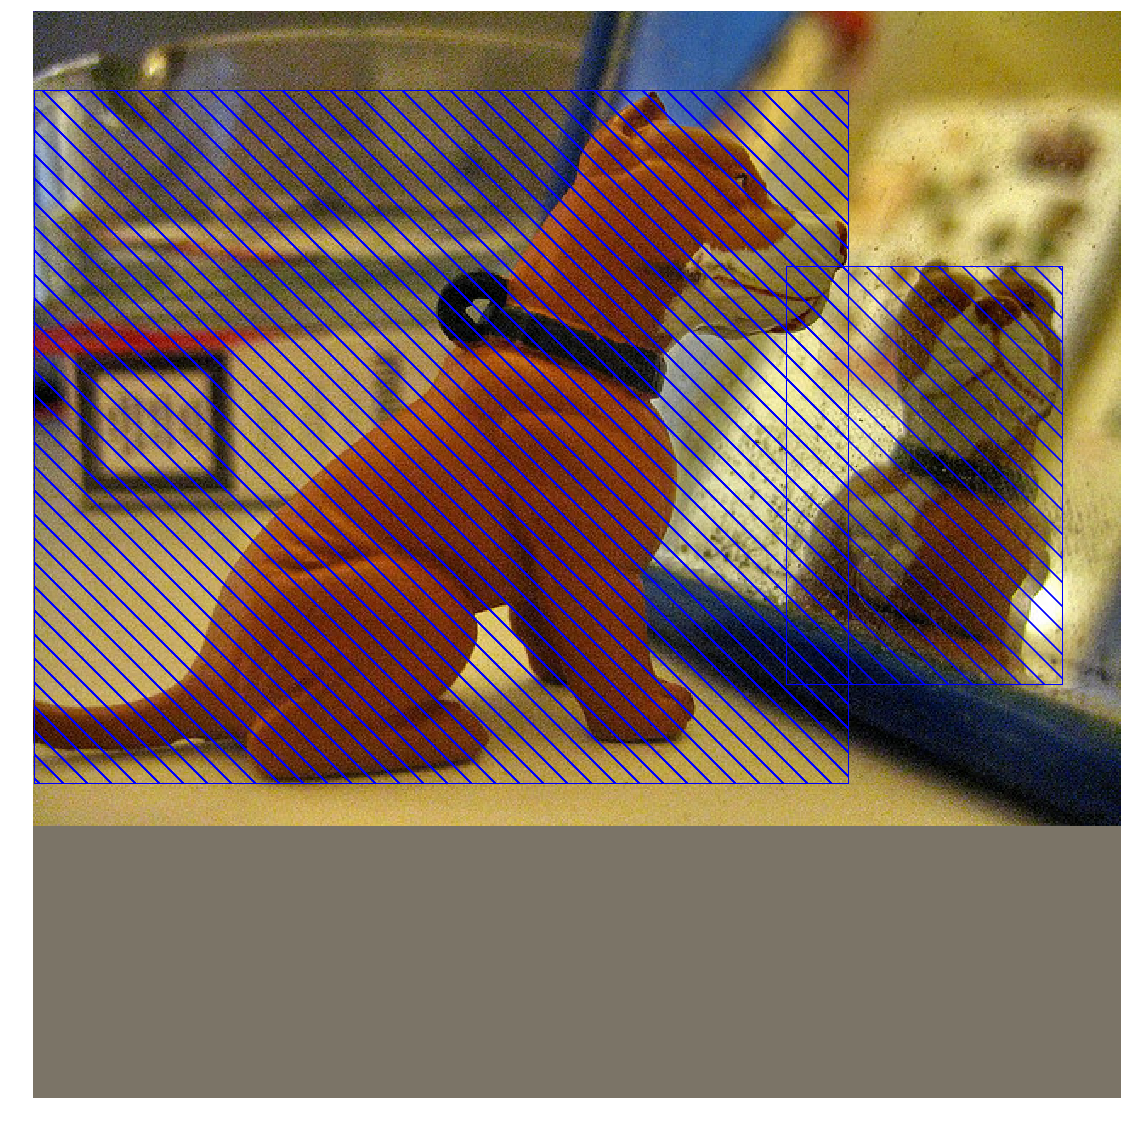

In [31]:
i = 4
catIDs = coco.getCatIds()
categories = {r["id"]: r["name"] for r in coco.loadCats(catIDs)}
plt.figure(figsize=(20,20))
a = plt.imshow((imgs[i,:,:,:] + [103.939, 116.779, 123.68]).astype(np.uint8)[:,:,::-1])
#print([categories[l] for l in labels[i]])
# This is kludgey but it's just a check:
seen = {}
anchors = anchors_all_levels(imgs.shape[1:3])
anns_convert = bbox_decode(anchors, anns[i,:,:])
for row in anns_convert:
    row = tuple(row)
    if row in seen:
        continue
    seen[row] = True
    x1,y1,x2,y2 = row
    w = x2 - x1
    h = y2 - y1
    a.axes.add_patch(matplotlib.patches.Rectangle((x1, y1), w, h, fill=False, hatch='\\', edgecolor="#0000ff"))
plt.axis("off")
plt.show()

```
generator: A generator or an instance of `Sequence` (`keras.utils.Sequence`)
        object in order to avoid duplicate data
        when using multiprocessing.
    The output of the generator must be either
    - a tuple `(inputs, targets)`
    - a tuple `(inputs, targets, sample_weights)`.
    This tuple (a single output of the generator) makes a single batch.
    Therefore, all arrays in this tuple must have the same length (equal
    to the size of this batch). Different batches may have different sizes.
    For example, the last batch of the epoch is commonly smaller than the
    others, if the size of the dataset is not divisible by the batch size.
    The generator is expected to loop over its data
    indefinitely. An epoch finishes when `steps_per_epoch`
    batches have been seen by the model.
```

In [29]:
g = coco_generator("/mnt/dev/datasets/coco/images/train2017", coco, 1, num_classes)
model.compile(
    loss={
        'regression'    : losses.smooth_l1(),
        'classification': losses.focal()
    },
    optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
)

In [32]:
with open("model.json", "w") as f:
    f.write(model.to_json())
model.fit_generator(
        generator=g,
        steps_per_epoch=10000,
        epochs=50,
        verbose=1,
        #callbacks=callbacks,
)

Epoch 1/50
10000/10000 [==============================] - 3210s 321ms/step - loss: 1.0612 - regression_loss: 0.2990 - classification_loss: 0.7622
Epoch 2/50
10000/10000 [==============================] - 2976s 298ms/step - loss: 0.7147 - regression_loss: 0.2128 - classification_loss: 0.5019
Epoch 4/50
10000/10000 [==============================] - 2958s 296ms/step - loss: 0.6732 - regression_loss: 0.2005 - classification_loss: 0.4727
Epoch 5/50
10000/10000 [==============================] - 2955s 295ms/step - loss: 0.6577 - regression_loss: 0.1943 - classification_loss: 0.4633
Epoch 6/50
10000/10000 [==============================] - 2961s 296ms/step - loss: 0.6247 - regression_loss: 0.1877 - classification_loss: 0.4370
Epoch 7/50
 6575/10000 [==================>...........] - ETA: 16:55 - loss: 0.6153 - regression_loss: 0.1813 - classification_loss: 0.4341

KeyboardInterrupt: 

In [39]:
model.save_weights("model.h5")

In [30]:
model.load_weights("model-20180103.h5")

In [40]:
# Need anchors to do this!
boxes = bbox_decode_keras(model.outputs[0])

TypeError: bbox_decode_keras() missing 1 required positional argument: 'deltas'

In [32]:
imgs, [anns, labels] = g.__next__()

In [33]:
test = model.predict(imgs)